In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

import seaborn as sns

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('running on:', device)

running on: cuda:0


In [3]:
IMG_SIZE = 48

CLASSES = ['neutral', 'happy', 'surprised', 'sad', 'angry', 'disgusted', 'afraid']
NUM_CLASSES = len(CLASSES)

## Pre-processing

In [4]:
df_fer = pd.read_csv('data/fer2013.csv').iloc[:, 1:]
df_ferplus = pd.read_csv('data/ferplus2013.csv').iloc[:, 2:-3]
df = df_fer.join(df_ferplus)
# df.head(15)

df['emotion'] = df.iloc[:, 2:].idxmax(axis=1).tolist()
df = df.replace(dict(zip(pd.Series(CLASSES),pd.Series(CLASSES).index)))
# df.head(15)

print('number of images:', df.shape[0])
df = df[(df.iloc[:, 2:-1].max(axis=1) > 5)]
print('after removing images with unknown/unsure classification:', df.shape[0])
# df.head(15)

df = df.iloc[:, [0, 1, -1]]
# df.head(15)

number of images: 35887
after removing images with unknown/unsure classification: 27307


In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

images_np = np.array(df['pixels'])
label_np = np.array(df['emotion'])

images = []
labels = []

for i in range(df.shape[0]):
    b = bytes(int(p) for p in images_np[i].split())
    img = Image.frombuffer('L', (IMG_SIZE, IMG_SIZE), b)
    images.append(transform(img))
    labels.append(label_np[i])

In [6]:
label_counts = [0]*NUM_CLASSES

for i in range(len(labels)):
    label_counts[labels[i]] += 1

print('\033[4m{: <15} {: >10}\033[0m'.format('class', '#images'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >10}'.format(CLASSES[i], label_counts[i]))

class              #images
neutral               9494
happy                 8802
surprised             3461
sad                   2958
angry                 2096
disgusted               66
afraid                 430


In [7]:
train_split_pct = 0.8
train_len = int(len(labels) * train_split_pct)

train_images = images[:train_len]
train_labels = labels[:train_len]
test_images = images[train_len:]
test_labels = labels[train_len:]

print(f'train length: {len(train_labels)} ({len(train_labels)*100/len(labels):.1f}%)')
print(f'test length: {len(test_labels)} ({len(test_labels)*100/len(labels):.1f}%)')

train length: 21845 (80.0%)
test length: 5462 (20.0%)


In [8]:
BATCH_SIZE = 64


class CustomDataset(Dataset):
    
    def __init__(self, images, labels):      
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)


def get_loader(dataset):
    print('get_loader():')

    label_counts = [0]*NUM_CLASSES
    for i in range(len(dataset.labels)):
        label_counts[dataset.labels[i]] += 1

    class_weights = pow(np.array(label_counts) / sum(label_counts), -1)
    print('  class weights:', class_weights.round(3), '\n')

    sample_weights = [0]*len(dataset)
    for idx, (image, label) in enumerate(dataset):
        sample_weights[idx] = class_weights[label]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return DataLoader(dataset, BATCH_SIZE, sampler=sampler, shuffle=False)


train_loader = get_loader(train_dataset)
test_loader = get_loader(test_dataset)

get_loader():
  class weights: [  2.899   3.07    7.906   9.129  13.231 474.891  63.874] 

get_loader():
  class weights: [  2.788   3.238   7.825   9.667  12.274 273.1    62.068] 



In [9]:
samples_train = [0]*NUM_CLASSES
samples_test = [0]*NUM_CLASSES

for idx, (images, labels) in enumerate(train_loader):
    for i in range(len(images)):
        samples_train[labels[i].item()] += 1

for idx, (images, labels) in enumerate(test_loader):
    for i in range(len(images)):
        samples_test[labels[i].item()] += 1


print('\033[4m{: <15} {: >15} {: >20}\033[0m'.format('class', '#samples (train)', '#samples (test)'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >15} {: >20}'.format(CLASSES[i], samples_train[i], samples_test[i]))

class           #samples (train)      #samples (test)
neutral                    3114                  777
happy                      3188                  783
surprised                  3110                  783
sad                        3112                  783
angry                      3097                  822
disgusted                  3142                  750
afraid                     3082                  764


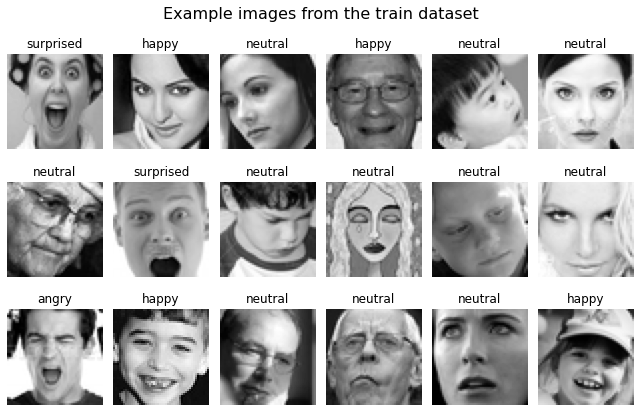

In [10]:
def imshow(dataset, title='', num_images=(3,6), rand=True):

    plt.figure(figsize=(num_images[1]*1.5, num_images[0]*2)); 
    plt.suptitle(title, fontsize=16)

    for i in range(num_images[0]):
        for j in range(num_images[1]):
            
            c = num_images[1]*i+(j+1)

            if not rand:
                idx = c
            else:
                idx = random.randint(0, len(dataset)-1)

            plt.subplot(num_images[0], num_images[1], c); plt.axis('off'); plt.title(CLASSES[dataset[idx][1]])
            plt.imshow(dataset[idx][0].permute(1,2,0), cmap='gray')

    plt.tight_layout(); plt.show()


imshow(train_dataset, 'Example images from the train dataset')